In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, accuracy_score, RocCurveDisplay
)

# Modelos de Crédito con Python

El objetivo es comparar el desempeño de dos modelos de clasificación:
- **Regresión Logística** (modelo base lineal).
- **Random Forest** (modelo no lineal de ensamble).

Ambos modelos buscan predecir la probabilidad de incumplimiento (default) a partir de variables crediticias como el límite de crédito,edad, historial de pagos, entre otras.

## Carga y exploración del dataset

Se utiliza el archivo `credit_default.csv` , que contiene 3,000 registros con información crediticia de clientes.

Las variables incluyen características demográficas y financieras como:
- `creditLimit`: límite de crédito asignado.
- `gender`: género del cliente (0 = mujer, 1 = hombre).
- `edu`: nivel educativo.
- `age`: edad.
- `nDelay`: número de pagos atrasados.
- `billAmt1` a `billAmt6`: montos de facturación en los últimos 6 meses.
- `default`: variable objetivo (1 = incumplimiento, 0 = cumplimiento).

A continuación se realiza una exploración inicial del dataset para revisar su estructura y valores estadísticos.


In [27]:
# ---------------------------------------------------------------
# 1. Cargar el dataset CSV
# ---------------------------------------------------------------
df = pd.read_csv("credit_default.csv")

print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nResumen estadístico:")
display(df.describe())


Dimensiones del dataset: (3000, 13)

Primeras filas:


,id,creditLimit,gender,edu,age,nDelay,billAmt1,billAmt2,billAmt3,billAmt4,billAmt5,billAmt6,default
0,1,4500,0,2,28,0,3915,3150,2475,2340,2385,2430,0
1,2,6000,0,2,24,0,2820,2700,2760,2400,2280,2280,1
2,3,3800,0,2,39,0,3572,3648,3762,2166,2204,2242,0
3,4,5500,1,1,27,0,5280,5445,5390,2585,2640,2695,1
4,5,18000,1,1,51,2,3780,3780,3780,1800,1620,720,0



Resumen estadístico:


,id,creditLimit,gender,edu,age,nDelay,billAmt1,billAmt2,billAmt3,billAmt4,billAmt5,billAmt6,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000
mean,833.833333,13473.733333,0.393667,1.854667,35.597667,0.666667,4015.068667,3872.950000,3759.448000,3415.14000,3171.521333,3037.122667,0.224333
std,552.862875,10476.373810,0.488644,0.805664,9.614847,1.060156,5890.372499,5718.558023,6025.629774,5156.82535,4865.605665,4744.482576,0.417212
min,1.000000,700.000000,0.000000,0.000000,18.000000,0.000000,-14074.000000,-2275.000000,-2313.000000,-2570.00000,-519.000000,-16056.000000,0.000000
25%,375.750000,4600.000000,0.000000,1.000000,28.000000,0.000000,268.250000,239.000000,215.750000,179.25000,162.000000,84.000000,0.000000
50%,750.500000,10900.000000,0.000000,2.000000,34.000000,0.000000,1718.000000,1680.000000,1554.000000,1446.50000,1350.000000,1219.000000,0.000000
75%,1250.250000,19475.000000,1.000000,2.000000,42.000000,2.000000,5100.000000,4920.000000,4641.500000,4330.50000,3876.000000,3653.250000,0.000000
max,2000.000000,66000.000000,1.000000,6.000000,71.000000,8.000000,49500.000000,47586.000000,128205.000000,55965.00000,49680.000000,42951.000000,1.000000


## Preparación de datos

Antes de entrenar los modelos, separamos las variables:
- **X** → predictores (todas las columnas excepto `default`).
- **y** → variable objetivo (`default`).

Además, se divide el dataset en dos conjuntos:
- **Entrenamiento (75%)**
- **Prueba (25%)**

Esto permite evaluar el rendimiento real del modelo con datos que no ha visto durante el entrenamiento.


In [28]:
# ---------------------------------------------------------------
# 2. Separar predictores (X) y variable objetivo (y)
# ---------------------------------------------------------------
X = df.drop(columns=["default"])
y = df["default"]

# Verificar balance de clases
print("Distribución de la variable objetivo:")
print(y.value_counts(normalize=True))


Distribución de la variable objetivo:
default
0    0.775667
1    0.224333
Name: proportion, dtype: float64


In [29]:
# ---------------------------------------------------------------
# 3. Dividir en train/test
# ---------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Tamaño de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño de prueba: {X_test.shape[0]}")


Tamaño de entrenamiento: 2250
Tamaño de prueba: 750


## Entrenamiento de los modelos

Se entrenan dos algoritmos distintos:

1. **Regresión Logística**  
   Modelo lineal que estima la probabilidad de default mediante una función logística.  
   Se escala la información usando `StandardScaler` para normalizar las variables numéricas.

2. **Random Forest**  
   Modelo de ensamble basado en múltiples árboles de decisión.  
   No requiere normalización y puede capturar relaciones no lineales entre las variables.

Ambos se ajustan con los mismos datos de entrenamiento para poder compararlos de forma justa.


In [30]:
# ---------------------------------------------------------------
# 4. Entrenar Regresión Logística y Random Forest
# ---------------------------------------------------------------
# Escalar datos para la regresión logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo 1: Regresión Logística
log_model = LogisticRegression(max_iter=500, random_state=42)
log_model.fit(X_train_scaled, y_train)

# Modelo 2: Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=6, random_state=42
)
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

## Evaluación de desempeño

Para cada modelo se calculan las siguientes métricas:

- **Accuracy:** porcentaje de predicciones correctas.  
- **Curva ROC-AUC:** mide la capacidad del modelo para distinguir entre clases (1 = default, 0 = no default).  
- **Matriz de confusión:** muestra cuántos casos fueron correctamente o incorrectamente clasificados.

Estas gráficas permiten comparar el rendimiento de ambos modelos de forma visual y cuantitativa.



📊 Evaluación - Regresión Logística
Accuracy: 0.7973
AUC: 0.7445


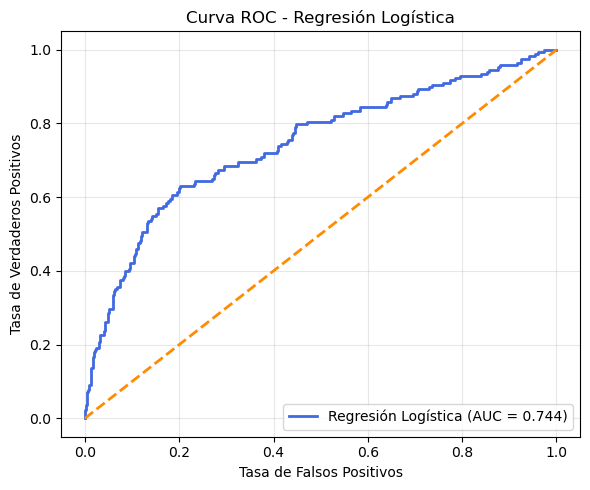

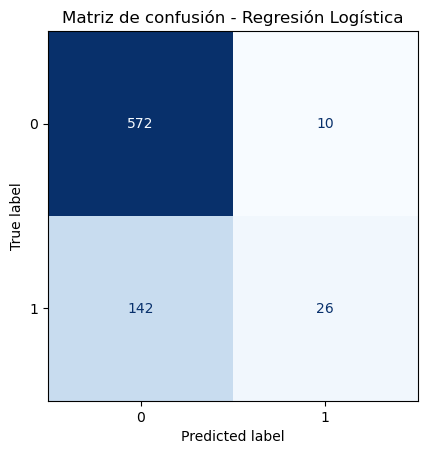


📊 Evaluación - Random Forest
Accuracy: 0.7973
AUC: 0.7613


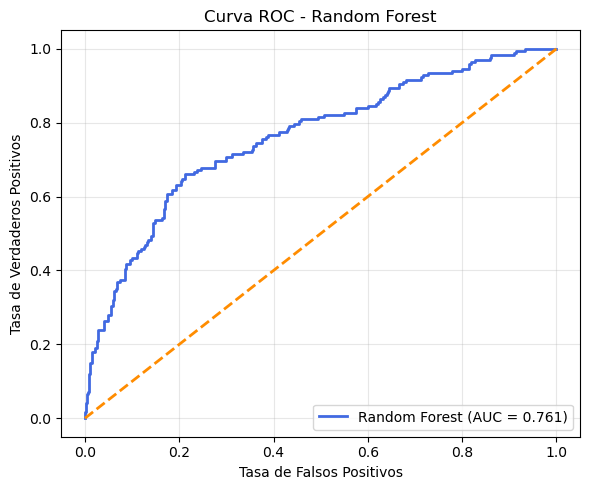

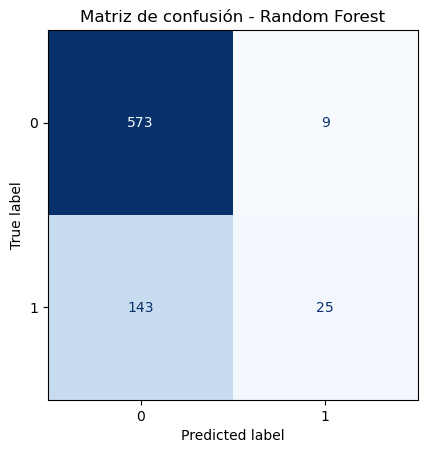

In [ ]:
# ---------------------------------------------------------------
# 5. Evaluación de ambos modelos 
# ---------------------------------------------------------------
def evaluar_modelo(nombre, modelo, X_test, y_test, escalado=False):
    # Escalado opcional
    if escalado:
        X_test_in = X_test_scaled
    else:
        X_test_in = X_test

    y_pred = modelo.predict(X_test_in)
    y_proba = modelo.predict_proba(X_test_in)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    model_auc = auc(fpr, tpr)

    # --- MÉTRICAS EN CONSOLA ---
    print(f"\n📊 Evaluación - {nombre}")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {model_auc:.4f}")

    # --- CURVA ROC PERSONALIZADA ---
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="royalblue", lw=2,
             label=f"{nombre} (AUC = {model_auc:.3f})")
    plt.plot([0, 1], [0, 1], color="darkorange", linestyle="--", lw=2)
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title(f"Curva ROC - {nombre}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"ROC_{nombre.replace(' ', '_')}.png", bbox_inches="tight")
    plt.show()

    # --- MATRIZ DE CONFUSIÓN ---
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues", colorbar=False)
    plt.title(f"Matriz de confusión - {nombre}")
    plt.savefig(f"Confusion_{nombre.replace(' ', '_')}.png", bbox_inches="tight")
    plt.show()

# Evaluación mejorada para ambos modelos
evaluar_modelo("Regresión Logística", log_model, X_test, y_test, escalado=True)
evaluar_modelo("Random Forest", rf_model, X_test, y_test)



### Curvas ROC-AUC
Las curvas ROC (Receiver Operating Characteristic) muestran la capacidad del modelo para distinguir entre clientes que **incumplen** (default = 1) y los que **no incumplen** (default = 0).  
- La **línea naranja diagonal** representa el desempeño de un modelo aleatorio (AUC = 0.5).  
- Cuanto más se aleje la curva azul de esa diagonal, **mejor es el modelo**.

En este caso:
- **Regresión Logística**: AUC ≈ 0.74  
- **Random Forest**: AUC ≈ 0.76  
Esto indica que ambos modelos tienen un poder de discriminación aceptable, y que el Random Forest logra una ligera mejora gracias a su capacidad de capturar relaciones no lineales entre variables.

### Matrices de confusión
Las matrices de confusión permiten analizar los **aciertos y errores** de cada modelo.

- Los valores en la **diagonal principal** representan las predicciones correctas.  
- Los valores fuera de la diagonal son errores de clasificación.

Interpretación:
- La mayoría de los casos de clase **0 (no default)** se predicen correctamente, lo que significa que los modelos **identifican bien a los buenos pagadores**.  
- Sin embargo, hay algunos **falsos negativos**, es decir, personas que incumplen pero el modelo las clasificó como cumplidoras.  
  Este tipo de error es relevante porque representa **riesgo financiero real** (el banco aprobaría un crédito riesgoso).


## Gráficas de interacción entre variables

Se visualizan tres combinaciones de variables para entender cómo interactúan en relación con la probabilidad de default:

1. `creditLimit` vs `age`
2. `nDelay` vs `billAmt1`
3. `billAmt2` vs `billAmt3`

Cada punto representa un cliente, y el color indica la **probabilidad de incumplimiento** predicha por el modelo logístico.  
Esto permite observar patrones: por ejemplo, clientes con más atrasos (`nDelay`) o límites de crédito más bajos suelen presentar mayor riesgo.


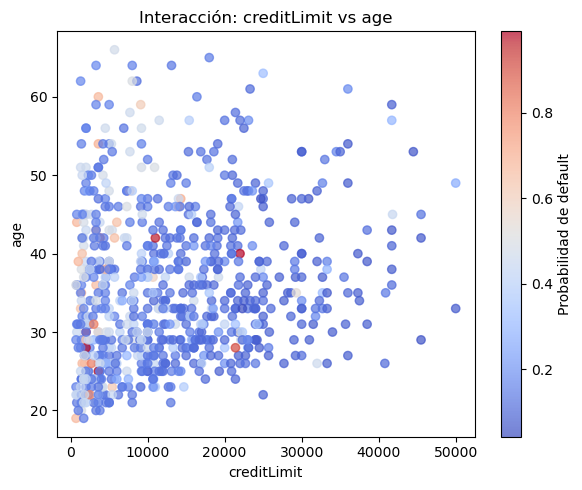

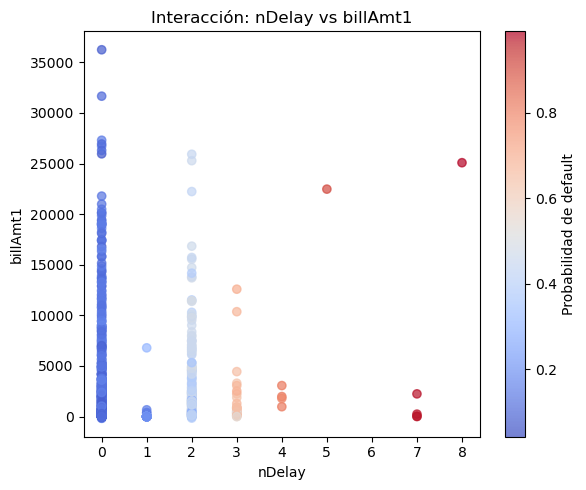

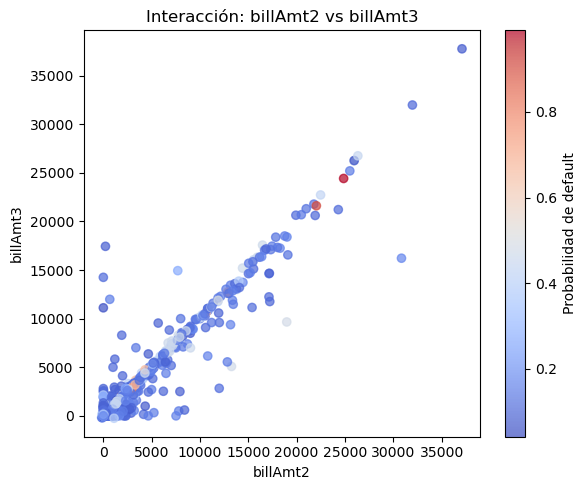

In [32]:
# ---------------------------------------------------------------
# 6. Gráficas de interacción entre pares de variables
# ---------------------------------------------------------------
def interaction_plot(x, y, z, xlabel, ylabel, title, filename):
    plt.figure(figsize=(6, 5))
    sc = plt.scatter(x, y, c=z, cmap="coolwarm", alpha=0.7)
    plt.colorbar(sc, label="Probabilidad de default")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Probabilidades con modelo logístico (para visualización)
proba = log_model.predict_proba(X_test_scaled)[:, 1]

pairs = [
    ("creditLimit", "age"),
    ("nDelay", "billAmt1"),
    ("billAmt2", "billAmt3")
]

for i, (f1, f2) in enumerate(pairs, start=1):
    interaction_plot(
        X_test[f1], X_test[f2], proba,
        xlabel=f1,
        ylabel=f2,
        title=f"Interacción: {f1} vs {f2}",
        filename=f"interaccion_{i}.png"
    )


###  Gráficas de interacción entre variables
Estas visualizaciones muestran **cómo dos variables influyen juntas** en la probabilidad de default predicha por el modelo logístico.  
El color indica el riesgo: **azul = bajo riesgo**, **rojo = alto riesgo**.

**a) `creditLimit` vs `age`**  
Se observa que las probabilidades de incumplimiento son más altas en clientes **jóvenes con límites de crédito bajos**.  
Esto puede reflejar menor estabilidad económica o historial financiero limitado.

**b) `nDelay` vs `billAmt1`**  
Los clientes con **más pagos atrasados (nDelay alto)** y **montos de facturación elevados** tienden a tener mayor probabilidad de default.  
El patrón muestra claramente cómo el número de atrasos incrementa el riesgo crediticio.

**c) `billAmt2` vs `billAmt3`**  
Existe una **correlación positiva fuerte** entre ambos montos (valores altos en ambos ejes).  
Los casos rojos (alto riesgo) suelen encontrarse en los extremos altos, lo que sugiere que quienes acumulan deudas grandes en meses consecutivos presentan mayor probabilidad de incumplimiento.



## Métricas adicionales y comparación

 Visualizaciones complementarias:

- **Importancia de variables:** indica cuáles características influyen más en el modelo Random Forest.  
- **Comparación de curvas ROC:** permite observar simultáneamente la capacidad de discriminación de ambos modelos.  
- **Distribución de probabilidades:** muestra cómo cada modelo estima el riesgo de incumplimiento.

Estas gráficas ayudan a interpretar los resultados más allá de las métricas numéricas.


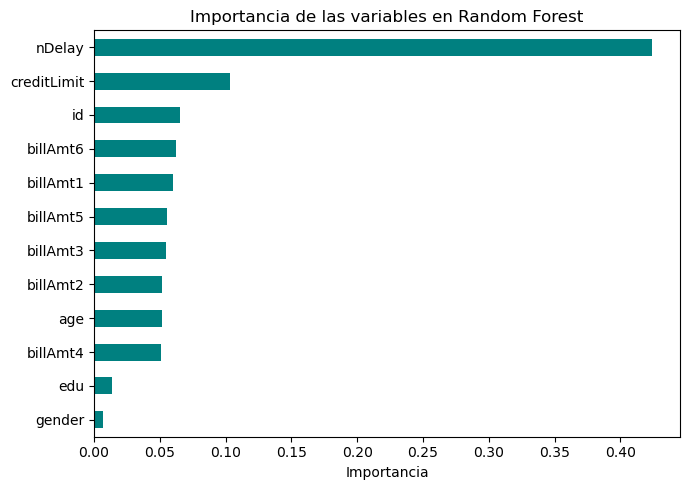

In [37]:
# ---------------------------------------------------------------
# Importancia de características (Random Forest)
# ---------------------------------------------------------------
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(7,5), color="teal")
plt.title("Importancia de las variables en Random Forest")
plt.xlabel("Importancia")
plt.tight_layout()
plt.savefig("feature_importance.png", bbox_inches="tight")
plt.show()


###  Importancia de las variables (Random Forest)
El gráfico de barras muestra el peso que cada variable tiene dentro del modelo Random Forest.  
- Las variables más importantes suelen ser **creditLimit**  y el **número de atrasos (nDelay)**. 
- Esto confirma que el **historial de pago** y el **nivel de deuda acumulada** son los factores más determinantes en el riesgo crediticio.

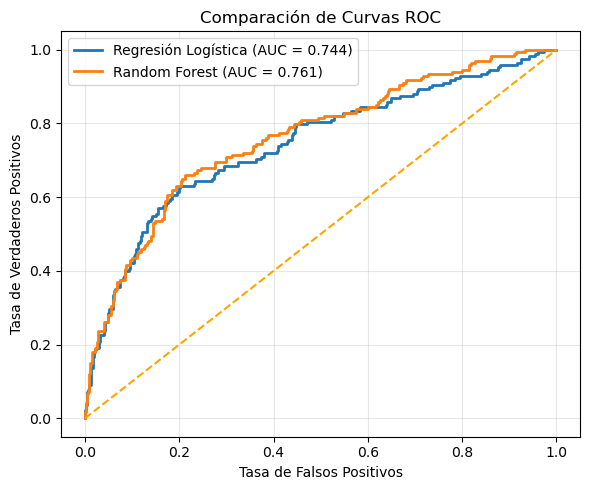

In [38]:
# ---------------------------------------------------------------
# Comparación de las curvas ROC de ambos modelos
# ---------------------------------------------------------------
from sklearn.metrics import roc_curve, auc

# Logistic
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
auc_log = auc(fpr_log, tpr_log)

# Random Forest
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_log, tpr_log, label=f"Regresión Logística (AUC = {auc_log:.3f})", lw=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", lw=2)
plt.plot([0,1],[0,1],"--", color="orange")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Comparación de Curvas ROC")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("ROC_comparacion.png", bbox_inches="tight")
plt.show()


### 5. Comparación de curvas ROC
En la gráfica combinada, el modelo Random Forest (línea naranja) se mantiene **ligeramente por encima** de la curva de Regresión Logística (línea azul) a lo largo de todo el rango.  
Esto significa que **el Random Forest clasifica mejor en casi todos los umbrales de decisión**.


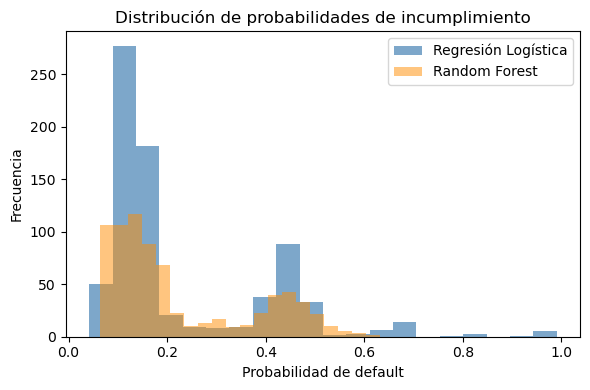

In [39]:
# ---------------------------------------------------------------
# Distribución de las probabilidades de default
# ---------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.hist(y_proba_log, bins=20, color="steelblue", alpha=0.7, label="Regresión Logística")
plt.hist(y_proba_rf, bins=20, color="darkorange", alpha=0.5, label="Random Forest")
plt.xlabel("Probabilidad de default")
plt.ylabel("Frecuencia")
plt.title("Distribución de probabilidades de incumplimiento")
plt.legend()
plt.tight_layout()
plt.savefig("probability_distribution.png", bbox_inches="tight")
plt.show()


###  Distribución de probabilidades
La distribución de probabilidades muestra cómo cada modelo asigna riesgo a los clientes.  
- En ambos modelos, la mayoría de las observaciones se concentran cerca de 0 (bajo riesgo), lo que coincide con el hecho de que la mayoría de los clientes no incumplen.  
- Sin embargo, el Random Forest tiende a **generar valores más extremos**, separando mejor los casos de alto riesgo, mientras que la regresión logística produce una distribución más suave.

##  Conclusiones generales

- La **regresión logística** ofrece una buena precisión (≈79%) y un AUC de alrededor de 0.74, lo que demuestra que es un modelo confiable y fácil de interpretar.  
- El **Random Forest** mejora ligeramente el AUC (≈0.76) al capturar relaciones no lineales, aunque pierde algo de interpretabilidad.  
- Las gráficas de interacción evidencian cómo los atrasos en los pagos y los montos de facturación son factores determinantes en el riesgo de default.  
- En comparación con la práctica de MATLAB, esta versión en Python ofrece una evaluación más completa, más visualizaciones  y mayor flexibilidad analítica.

En conclusión, Python no solo reproduce lo que hace MATLAB, sino que lo **supera en capacidad de análisis y presentación de resultados**.